MNS 4
===
Dominik Krzemiński

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pdb

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1. Synaptic current
a)

In [2]:
def euler(f_func, x_0, t_max, dt, **params):
    t = np.arange(0, t_max, dt)
    n = len(t)
    x = np.zeros((n,1))
    x[0] = x_0
    for i in range(1, n):
        x[i] = x[i-1] + f_func(x[i-1], t[i-1], **params)*dt
    return x

In [3]:
def g_syn(t, tau_syn=10*1e-3, g_max=50*1e-9):
    gvec = np.zeros(len(t))
    idcs = np.where(t>=0)[0]
    gvec[idcs] = (g_max*t[idcs]/tau_syn)*np.exp(-t[idcs]/tau_syn)
    return gvec


In [65]:
###################### defining constants
tau = 10*1e-3 #s
Em = -80*1e-3 # V
Rm = 10**7 # Ohm
Ie = 0
Esyn = -100*1e-3 #V
Eexc = 0
Einh = -100*1e-3 #V
#######################

tv = np.linspace(-0.1,0.4,200) #m

def voltage(v, t, Is, Ie=0):
    return (-v + Em - Rm*Is + Rm*Ie)/tau


In [66]:
def synaptic_values(Esyn, tv, shunting=0):
    dt = tv[-1]-tv[-2]
    gsyn = g_syn(tv, tau)
    v = np.zeros(len(tv))
    im = np.zeros(len(tv))
    isyn = np.zeros(len(tv))
    v[0] = Em
    for i in range(1, len(tv)):
        if shunting==0:
            isyn[i] = gsyn[i-1]*(v[i-1]-Esyn)
        elif shunting==1:
            isyn[i] = g_exc*(v[i-1]-Eexc) + g_inh*(v[i-1]-Einh)
        elif shunting==2:
            isyn[i] = gsyn[i-1]*(v[i-1]-Esyn) + g_exc*(v[i-1]-Eexc) + g_inh*(v[i-1]-Einh)
        v[i]    = v[i-1] + voltage(v[i-1], tv[i-1], isyn[i])*dt
        im[i]   = (v[i-1]-Em)/Rm
    return v, isyn, im, gsyn

def plotting_v_and_depend(tv, v, isyn, im, gsyn, txt=''):
    fig, ax1 = plt.subplots(1,2, figsize=(14,5))
    fig.subplots_adjust(wspace=0.4)
    ln1 = ax1[0].plot(tv, gsyn, 'r', label='g_syn')
    ax1[0].set_ylabel('g [S]')
    ax2 = ax1[0].twinx()
    ln2 = ax2.plot(tv, isyn, 'b', label='I_syn')
    ln3 = ax2.plot(tv, im, 'm', label='I_m')
    ax2.set_ylabel('I [A]')
    lns = ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax1[0].set_xlabel('time [s]')
    plt.legend(lns, labs, loc=1)

    ln1 = ax1[1].plot(tv, v, 'g', lw=2, label='V')
    ax1[1].set_xlabel('time [s]')
    ax1[1].set_ylabel('Potential $V(t)$ [V]')
    ax1[1].legend()
    plt.suptitle(txt, fontsize=14)
    plt.show()


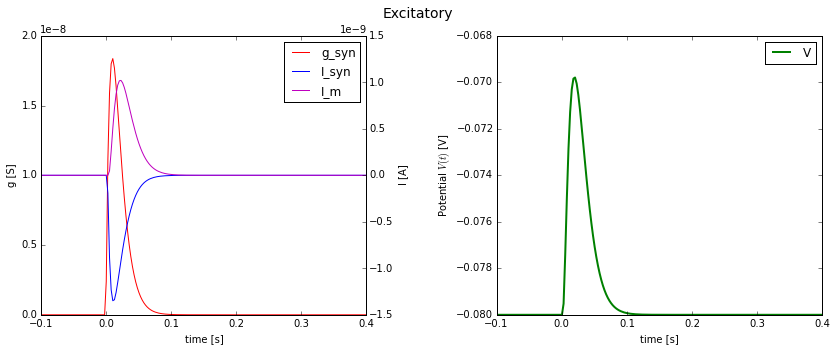

In [6]:
v, isyn, im, gsyn = synaptic_values(Eexc, tv)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'Excitatory')

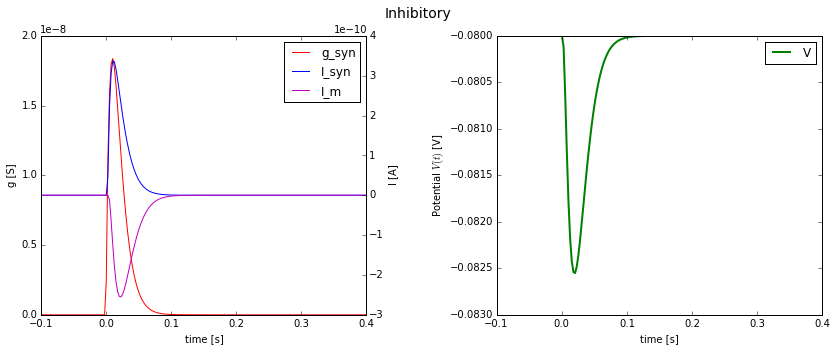

In [7]:
v, isyn, im, gsyn = synaptic_values(Einh, tv)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'Inhibitory')

b)

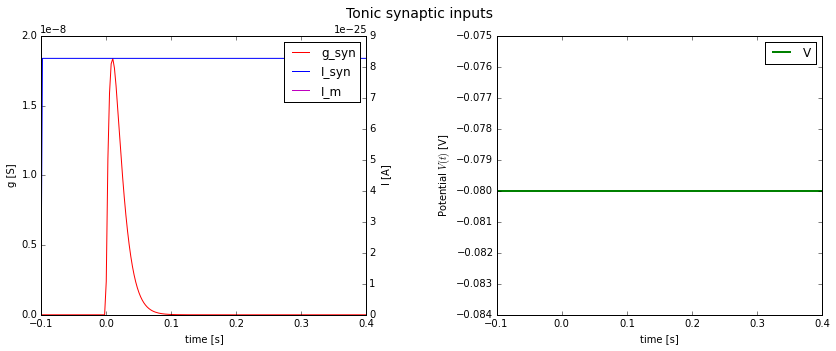

In [8]:
g_exc = 50*1e-9 #S
g_inh = 200*1e-9

v, isyn, im, gsyn = synaptic_values(Einh, tv, shunting=1)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'Tonic synaptic inputs')

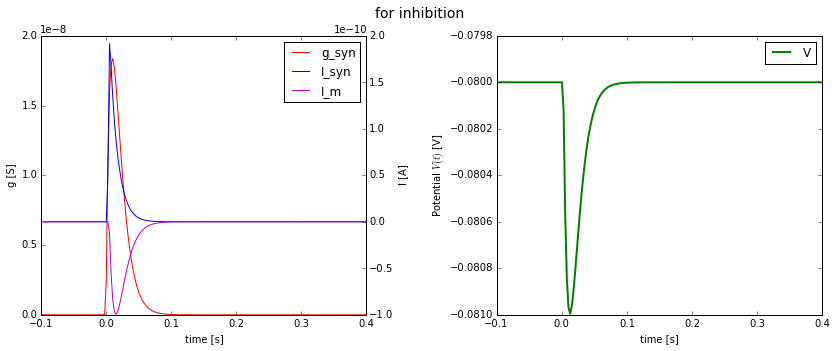

In [9]:
v, isyn, im, gsyn = synaptic_values(Einh, tv, shunting=2)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'for inhibition')

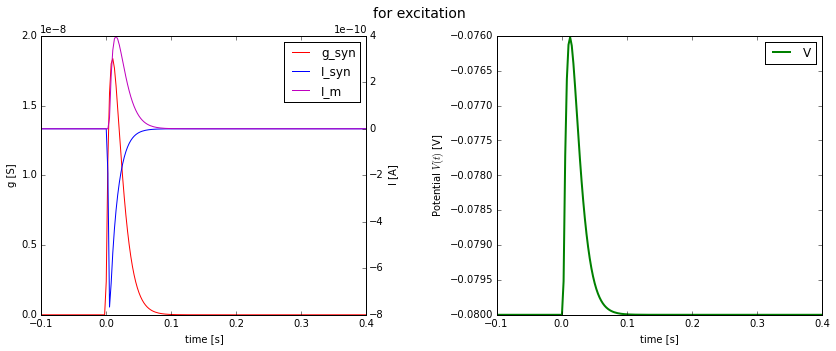

In [10]:
v, isyn, im, gsyn = synaptic_values(Eexc, tv, shunting=2)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'for excitation')

### 2. Integrate-and-fire neuron.

a)

In [68]:
def synaptic_values_lif(Esyn, tv, Vthresh, Vreset, i_e):
    dt = tv[-1]-tv[-2]
    gsyn = g_syn(tv, tau)
    v = np.zeros(len(tv))
    im = np.zeros(len(tv))
    isyn = np.zeros(len(tv))
    v[0] = Em
    v_update = 0
    for i in range(1, len(tv)):
        #print(v_update)
        v_update = v[i-1] + voltage(v[i-1], tv[i-1], isyn[i], i_e)*dt
        #pdb.set_trace()
        if v_update>= Vthresh:
            v[i] = Vreset
        else:
            v[i] = v_update
        im[i] = (v[i-1]-Em)/Rm
    return v, isyn, im, gsyn

b)

In [69]:
def plotting_v(tv, v, txt=''):
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    fig.subplots_adjust(wspace=0.4)
    ln1 = ax.plot(tv, v, 'g', lw=2, label='V')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('Potential $V(t)$ [V]')
    ax.legend()
    plt.suptitle(txt, fontsize=13)
    plt.show()

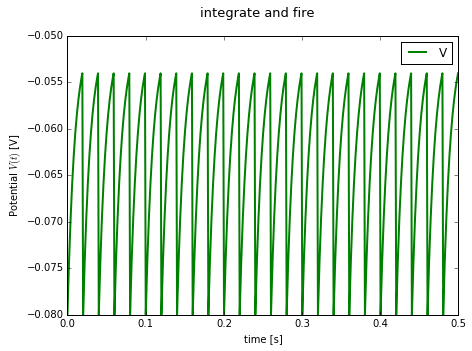

In [70]:
###################### new set of constants
tau = 10*1e-3 #s
Em = -80*1e-3 # V
Rm = 10**7 # Ohm
Ie = 0.3*1e-8
Esyn = -100*1e-3 #V
Eexc = 0
Einh = -100*1e-3 #V
v_th = -54*1e-3 #V
v_reset = Em
#######################

tv = np.linspace(0,0.5,500)
v, isyn, im, gsyn = synaptic_values_lif(Esyn, tv, v_th, v_reset, Ie)
plotting_v(tv, v, 'integrate and fire')

In [63]:
print('Firing rate: {} Hz'.format(len(np.where(np.max(v)==v)[0])*1./0.5))

Firing rate: 50.0 Hz


c)

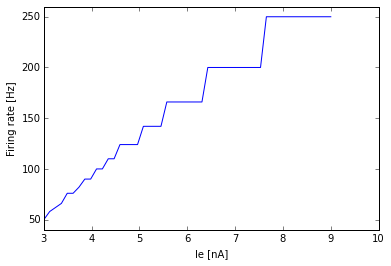

In [81]:
ie_range = np.linspace(0.3, 0.9)*1e-8

frates = np.zeros(len(ie_range))

for e, ie in enumerate(ie_range):
    v, isyn, im, gsyn = synaptic_values_lif(Esyn, tv, v_th, v_reset, ie)
    frates[e] = len(np.where(np.max(v)==v)[0])*1./0.5

plt.plot(ie_range*1e9, frates)
plt.xlabel('Ie [nA]')
plt.ylabel('Firing rate [Hz]')
plt.ylim([min(frates)-10, max(frates)+10])
plt.show()

### 3. Synaptically coupled IF neurons.

a)

In [86]:
###################### changing constants for ex 3
tau = 10*1e-3 #s
Em = -70*1e-3 # V
Rm = 10**7 # Ohm
Ie = 25*1e-3/Rm # to have 25 mV
Esyn = -100*1e-3 #V
v_th = -54*1e-3 #V
v_reset = Em
#######################

In [131]:
def g_syn_temp(t, treset, tau_syn=10*1e-3, g_max=50*1e-9):
    gvec = np.zeros(len(t))
    idcs = np.where(t>=treset)[0]
    #pdb.set_trace()
    gvec[idcs] = (g_max*t[idcs]/tau_syn)*np.exp(-t[idcs]/tau_syn)
    return gvec

def coupled_if(Esyn, Vthresh, Vreset, tv, i_e):
    dt = tv[-1]-tv[-2]
    v_1 = np.zeros(len(tv))
    v_2 = np.zeros(len(tv))
    im = np.zeros(len(tv))
    isyn_1 = np.zeros(len(tv))
    isyn_2 = np.zeros(len(tv))
    v_1[0] = Em
    v_2[0] = Vthresh
    v1_update = 0
    v2_update = 0
    gsyn_1 = g_syn_temp(tv, 0, tau, g_max=5*1e-9)
    gsyn_2 = g_syn_temp(tv, 0.05, tau, g_max=5*1e-9)
    for i in range(1, len(tv)):
        isyn_1[i] = gsyn_1[i-1]*(v_1[i-1]-Esyn)
        isyn_2[i] = gsyn_2[i-1]*(v_2[i-1]-Esyn)
        v1_update = v_1[i-1] + voltage(v_1[i-1], tv[i-1], isyn_1[i], i_e)*dt
        v2_update = v_2[i-1] + voltage(v_2[i-1], tv[i-1], isyn_2[i], i_e)*dt
        if v1_update>= Vthresh:
            v_1[i] = Vreset
            gsyn_2 = g_syn_temp(tv, tv[i], tau, g_max=5*1e-9)
        else:
            v_1[i] = v1_update
        if v2_update>= Vthresh:
            v_2[i] = Vreset
            gsyn_1 = g_syn_temp(tv, tv[i], tau, g_max=5*1e-9)
        else:
            v_2[i] = v2_update
    return v_1, v_2

def plotting_v(tv, v1, v2, txt=''):
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    fig.subplots_adjust(wspace=0.4)
    ln1 = ax.plot(tv, v1, 'g', label='V 1')
    ln2 = ax.plot(tv, v2, 'm', label='V 2')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('Potential $V(t)$ [V]')
    ax.legend()
    plt.suptitle(txt, fontsize=13)
    plt.show()

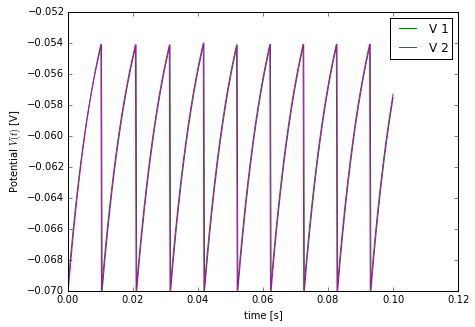

In [134]:
tv = np.linspace(0,0.1,500)
v1, v2 = coupled_if(Esyn, v_th, v_reset, tv, Ie)
plotting_v(tv, v1, v2)

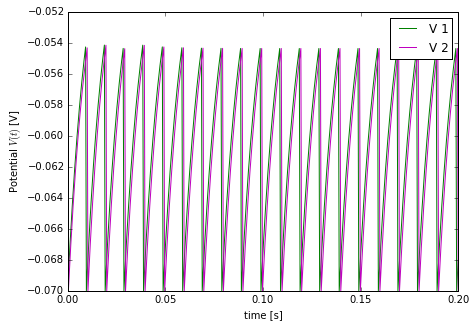

In [135]:
tv = np.linspace(0,0.2,500)
v1, v2 = coupled_if(0, v_th, v_reset, tv, Ie)
plotting_v(tv, v1, v2)